In [2]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification
import numpy as np
import flask
from flask import Flask, request, jsonify
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer


/Users/ayushisingh/Downloads/genai/mentalhealth_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Step 1: Data Preparation & Preprocessing 

# Download datasets
os.makedirs("data/full_dataset", exist_ok=True)
os.system("wget https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz")


--2025-04-08 01:02:31--  https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.202.10, 18.164.202.35, 18.164.202.62, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.202.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28022709 (27M) [application/gzip]
Saving to: ‘empatheticdialogues.tar.gz’

     0K .......... .......... .......... .......... ..........  0% 4.29M 6s
    50K .......... .......... .......... .......... ..........  0% 12.1M 4s
   100K .......... .......... .......... .......... ..........  0% 5.48M 4s
   150K .......... .......... .......... .......... ..........  0% 8.51M 4s
   200K .......... .......... .......... .......... ..........  0% 8.13M 4s
   250K .......... .......... .......... .......... ..........  1% 7.63M 4s
   300K .......... .......... .......... .......... ..........  1% 16.9M 4s
   350K .......... ....

0

In [4]:
import tarfile
import os
def extract_empathetic_dialogues():
    tar_path = "empatheticdialogues.tar.gz"  # Assuming it's downloaded in the root directory
    extract_root = "data/full_dataset/empatheticdialogues"
    extracted_file = os.path.join(extract_root, "empatheticdialogues", "train.csv")  # Fixed path!

    # Only extract if not already extracted
    if not os.path.exists(extracted_file):
        if not os.path.exists(tar_path):
            raise FileNotFoundError("Tar file not found at root!")

        os.makedirs(extract_root, exist_ok=True)
        with tarfile.open(tar_path, "r:gz") as tar:
            tar.extractall(path=extract_root)

    # Load CSV (flexible to skip bad lines)
    df = pd.read_csv(
        extracted_file,
        dtype=str,
        on_bad_lines='skip'  # For malformed rows
    )

    print("✅ EmpatheticDialogues loaded! Columns:", df.columns.tolist())
    return df

# Load the dataset
empathetic_dialogues_df = extract_empathetic_dialogues()


/var/folders/6k/rz430_fx5092wnjnr2wm6nkc0000gn/T/ipykernel_5993/3014785372.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_root)


✅ EmpatheticDialogues loaded! Columns: ['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags']


In [5]:
# Print first 5 rows of the dataset
print(empathetic_dialogues_df.head())


        conv_id utterance_idx      context  \
0  hit:0_conv:1             1  sentimental   
1  hit:0_conv:1             2  sentimental   
2  hit:0_conv:1             3  sentimental   
3  hit:0_conv:1             4  sentimental   
4  hit:0_conv:1             5  sentimental   

                                              prompt speaker_idx  \
0  I remember going to the fireworks with my best...           1   
1  I remember going to the fireworks with my best...           0   
2  I remember going to the fireworks with my best...           1   
3  I remember going to the fireworks with my best...           0   
4  I remember going to the fireworks with my best...           1   

                                           utterance     selfeval tags  
0  I remember going to see the fireworks with my ...  5|5|5_2|2|5  NaN  
1  Was this a friend you were in love with_comma_...  5|5|5_2|2|5  NaN  
2                This was a best friend. I miss her.  5|5|5_2|2|5  NaN  
3                     

/var/folders/6k/rz430_fx5092wnjnr2wm6nkc0000gn/T/ipykernel_5993/1825210941.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=empathetic_dialogues_df['context'], order=empathetic_dialogues_df['context'].value_counts().index, palette='viridis')


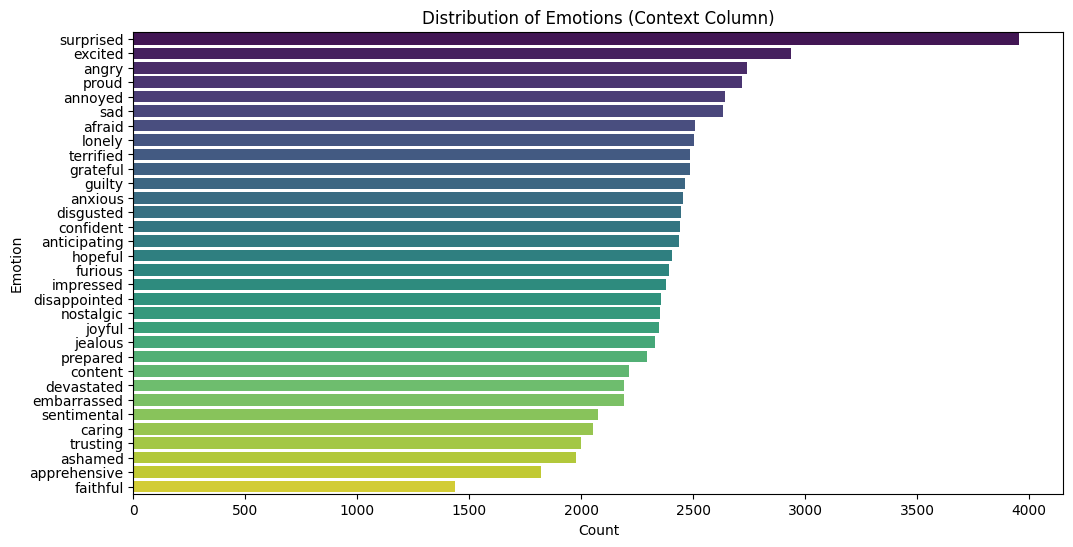

In [6]:
# 1. Emotion (Context) Distribution
plt.figure(figsize=(12, 6))
sns.countplot(y=empathetic_dialogues_df['context'], order=empathetic_dialogues_df['context'].value_counts().index, palette='viridis')
plt.title("Distribution of Emotions (Context Column)")
plt.xlabel("Count")
plt.ylabel("Emotion")
plt.show()

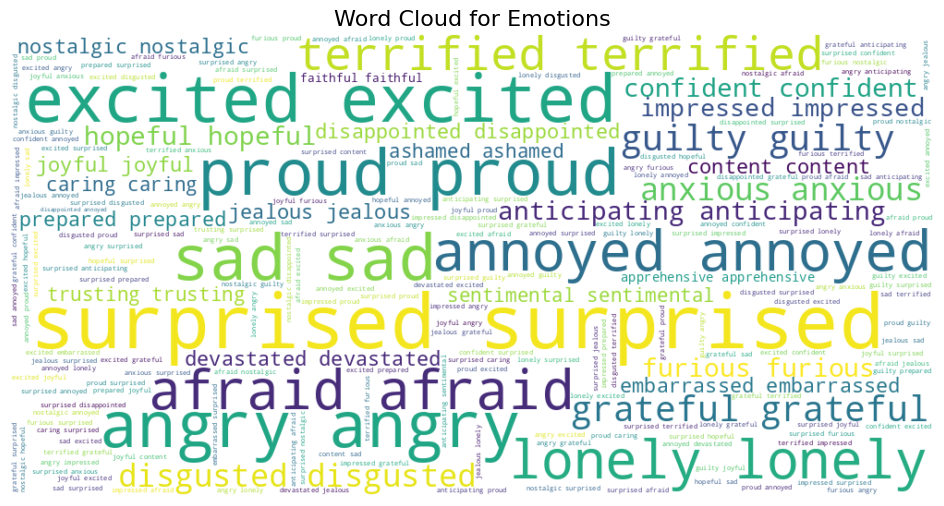

In [7]:
from wordcloud import WordCloud
# Combine all emotion labels into a single text corpus
emotion_text = " ".join(empathetic_dialogues_df['context'].dropna().astype(str))

# Generate WordCloud for emotions
wordcloud = WordCloud(width=1000, height=500, background_color="white", colormap="viridis").generate(emotion_text)

# Plot the WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Emotions", fontsize=16)
plt.show()


In [8]:
print(empathetic_dialogues_df['speaker_idx'].value_counts())


speaker_idx
27     2808
1      2580
126    1937
4      1885
238    1747
       ... 
492       2
71        2
783       2
730       2
757       2
Name: count, Length: 789, dtype: int64


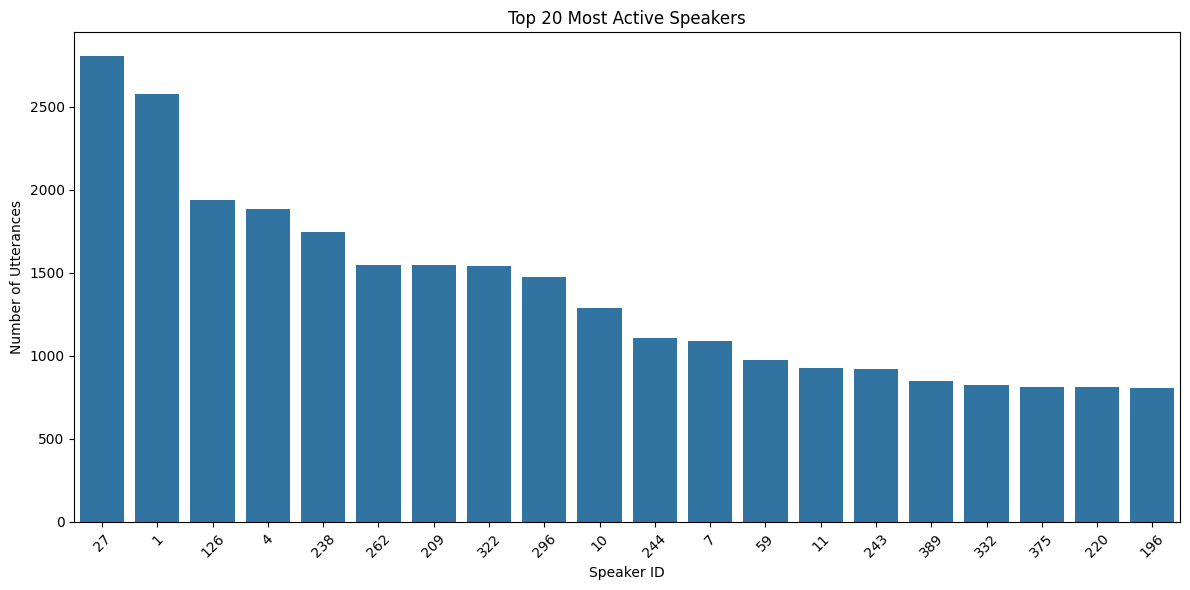

In [9]:
# Plot the top 20 most active speakers
top_speakers = empathetic_dialogues_df['speaker_idx'].value_counts().head(20)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_speakers.index.astype(str), y=top_speakers.values)
plt.title("Top 20 Most Active Speakers")
plt.xlabel("Speaker ID")
plt.ylabel("Number of Utterances")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
os.makedirs("data/processed", exist_ok=True)

empathetic_dialogues_df.to_csv("data/processed/empathetic_dialogues.csv", index=False)
